In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import libactive; reload(libactive)
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
cm = sns.color_palette('gist_ncar', 7, desat=0.4)

In [10]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [11]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-86e7f06a-465e-459f-b19d-db0b845ad6df.json']
Current commit: 9d93dd0



Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
results_plots[0][1][0].columns

Index(['x', 'accuracy_score', 'f1_score', 'roc_auc_score', 'time',
       'time_total', 'uncertainty_average', 'uncertainty_min',
       'uncertainty_max', 'uncertainty_variance',
       'uncertainty_average_selected', 'uncertainty_min_selected',
       'uncertainty_max_selected', 'uncertainty_variance_selected',
       'entropy_max', 'n_support', 'contradictory_information'],
      dtype='object')

### List of stopping conditions & metrics to compute

In [13]:
reload(libstop); from libstop import *
def acc_wrapper(**kwargs):
    x, diffs = first_acc(**kwargs)
    return [np.nan] +diffs

stuff = {
    #'GOAL': [partial(ZPS, order=2), acc_wrapper, None], 
    #'SSNCut': [SSNCut, SSNCut_values, None], 
    #'SC_entropy_mcs': [SC_entropy_mcs, 'entropy_max', 1e-2], 
    #'SC_oracle_acc': [SC_oracle_acc_mcs, SC_oracle_acc_mcs_values, 0.9], 
    #'SC_mes': [SC_mes, 'expected_error_min', 1e-2], 
    #'Stabilizing Predictions': [stabilizing_predictions, kappa_metric, 0.99], 
    'Performance Convergence': [performance_convergence, fscore, None], 
    #'Uncertainty Convergence': [uncertainty_convergence, partial(metric_selected, metric=classifier_entropy), None], 
    #'Max Confidence': [max_confidence, partial(metric_selected, metric=classifier_entropy), 1e-3],
    #'EVM': [EVM, 'uncertainty_variance_selected', None], 
    #'VM': [VM, 'uncertainty_variance_selected', None], 
    #'N support vectors': [None, 'n_support', None], 
    #'Contradictory Information': [contradictory_information, 'contradictory_information', None], 
    #'Kappa First': [None, kappa_metric_first, None],
    #'Classification Change': [classification_change, classification_change_values, 1],
    #'Overall Uncertainty': [overall_uncertainty, 'uncertainty_average', 1e-2]
}

conditions = [x[0] for x in stuff.values()]
metric_values = [x[1] for x in stuff.values()]
thresholds = [x[2] for x in stuff.values()]
names = list(stuff.keys())

### Create the unlabelled pools

In [14]:
results = results_plots[0][1]
conf = results_plots[0][0]
X, y = getattr(libdatasets, conf.dataset_name)(None)
unlabelled_pools = []
y_oracles = []
# WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
for i in range(len(results)):
    _, X_unlabelled, _, Y_oracle, _, _ = active_split(
        X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
    )
    unlabelled_pools.append(X_unlabelled)
    y_oracles.append(Y_oracle)

### Evaluate the metrics

In [15]:
computed = {}

In [16]:
#del computed['Performance Convergence']

In [17]:
for metric, name in zip(metric_values, names):
    if name in computed:
        continue
    if isinstance(metric, str):
        values = np.array([results[i][metric] for i in range(len(results))])
    else:
        values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])

    computed[name] = values

In [18]:
computed['Performance Convergence'] = np.array([list(computed['Performance Convergence'][i]) for i in range(len(computed['Performance Convergence']))])
#computed['Uncertainty Convergence'] = np.array([list(computed['Uncertainty Convergence'][i]) for i in range(len(computed['Uncertainty Convergence']))])
#computed['Max Confidence'] = np.array([list(computed['Max Confidence'][i]) for i in range(len(computed['Max Confidence']))])

### Evaluate the conditions

In [19]:
computed_conds = {}

In [20]:
for cond, name in zip(conditions, names):
    if name in computed_conds:
        continue
    if cond is None:
        values = [None] * len(values)
    else:
        try:
            values = np.array([cond(**results[i], pre=computed[name][i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
        except FailedToTerminate:
            values = [None] * len(results)
    computed_conds[name] = values

In [21]:
list(computed_conds.keys())

['Performance Convergence']

### Create the plot

In [22]:
import seaborn as sns
cm = sns.color_palette('gist_ncar', 7, desat=0.4)

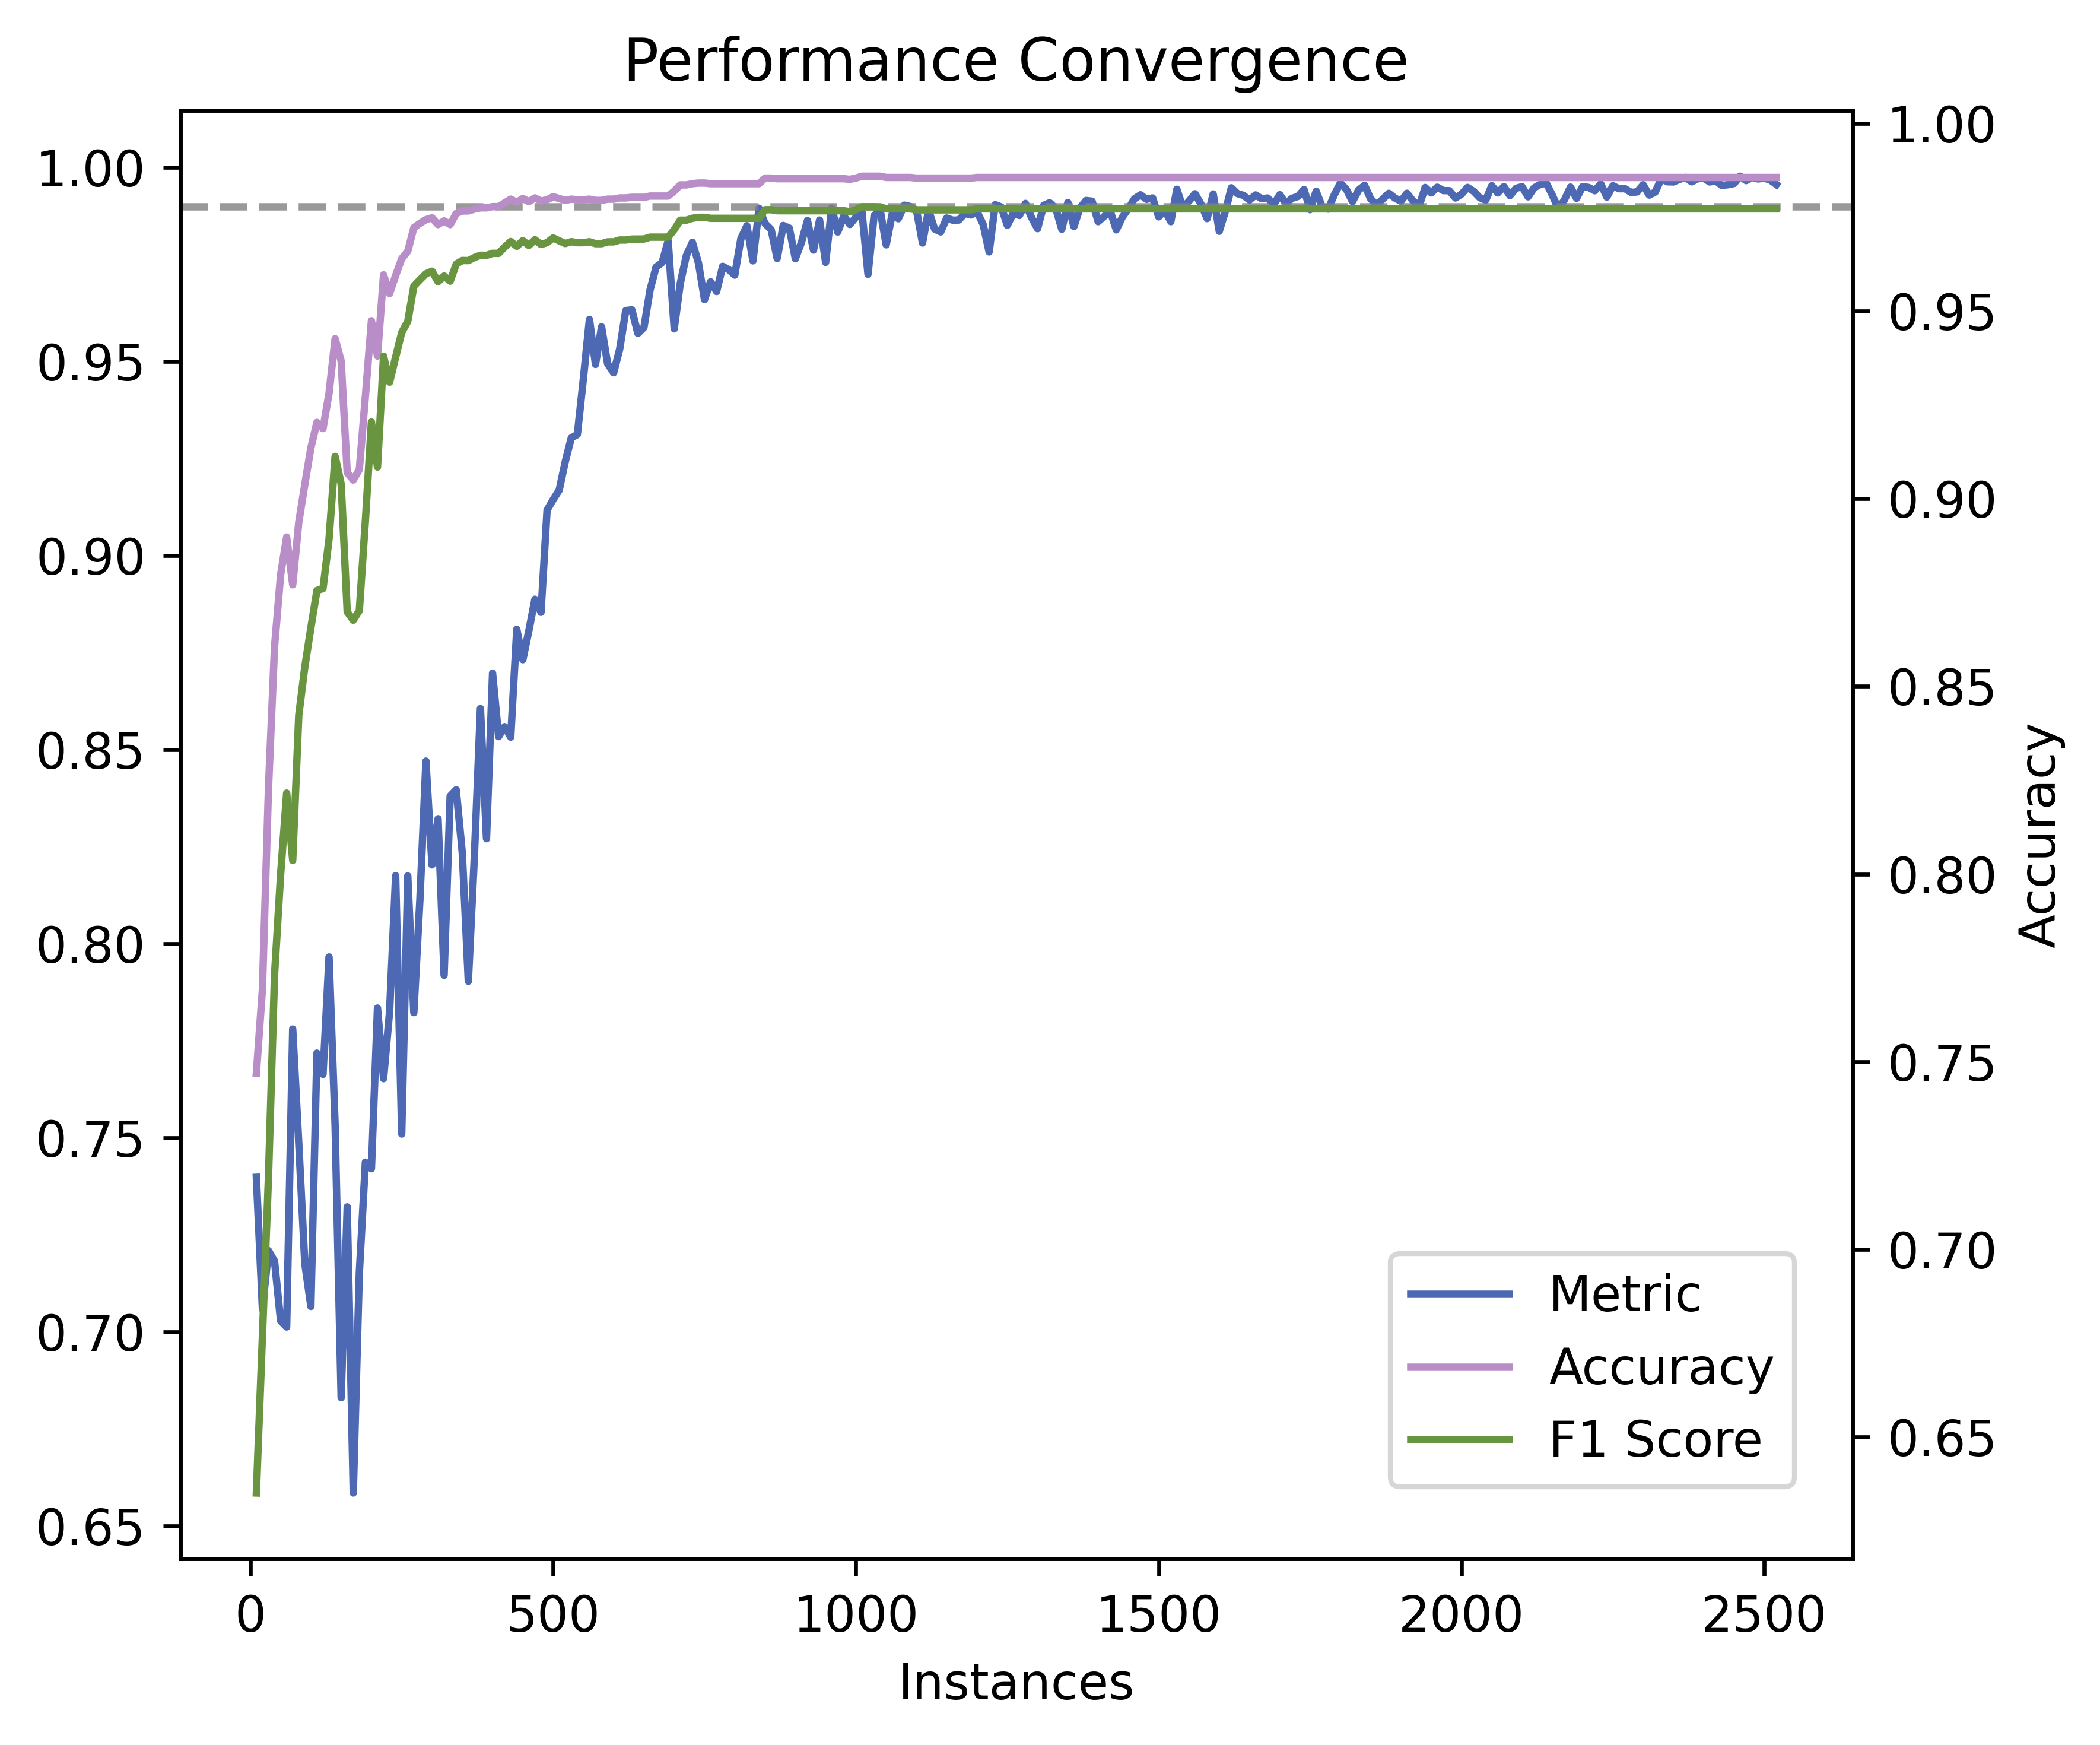

In [35]:
fig = plt.figure(figsize=(6,5), dpi=600)
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(1,1)
threshold_legend = True
stop_legend = True
for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
    x = j%5
    ax = fig.add_subplot(gs[j//5, x*4:(x+1)*4])
        
    values = computed[name]
        
    ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 else None)
    ax.axhline(0.99, color='grey', ls='--', alpha=0.8)
    
    for stop in computed_conds[name]:
        if stop is None:
            continue
        ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
        stop_legend = False
        
    if threshold is not None:
        ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
        threshold_legend = False
    
    ax2 = ax.twinx()
    ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
    ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)

    ax2.set_ylabel('Accuracy')
    ax.set_title(name)
    
    ax.set_xlabel("Instances")
       

fig.legend(bbox_to_anchor=(0.86, 0.3))
fig.tight_layout()

## GOAL

In [54]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [55]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-86e7f06a-465e-459f-b19d-db0b845ad6df.json']
Current commit: 9d93dd0



Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers, conditions={"GOAL": partial(libstop.ZPS, order=2)})

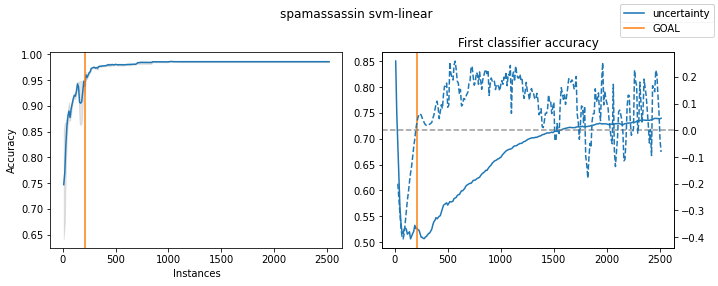

In [60]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(10, 4), extra=1, n_metrics_to_plot=1)